# Week 7 Transit Gaps Group Collaboration Notebook
## Team members: Monisha Reginald, Lucy Briggs, Carolyn Pugh

### Description
In this notebook, we will consolidate and provide additional narrative around the work we have developed so far as part of our preparation for our final project.

### Import Libraries

In [1]:
#imprt libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import fiona 
import numpy as np
import math
import folium

### Where do senior residents live within the City of LA? 
In this section, we analyze which areas have higher or lower densities of older residents using census data.  We look at both the block group and neighborhood level.

### Seniors Basemap

In [2]:
#read our pre-made GeoJSON
seniors = gpd.read_file('data/Seniors_Basemap.geojson')
seniors.sample(5)

,BG20,ShapeSTArea,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles,Pop Density,pctcat,geometry
1127,2190203,2.133087e+06,060372190203,1372,113,86,40,239,17.419825,0.823586,290.0,10%-20%,"POLYGON ((-118.31825 34.01828, -118.31931 34.0..."
1180,2281003,1.904647e+06,060372281003,1578,65,17,0,82,5.196451,0.735385,112.0,0%-10%,"POLYGON ((-118.24549 34.00837, -118.24668 34.0..."
486,1919022,4.527288e+06,060371919022,1584,174,82,9,265,16.729798,1.747988,152.0,10%-20%,"POLYGON ((-118.33627 34.08710, -118.33524 34.0..."
1802,1899032,4.221683e+05,060371899032,1517,96,63,63,222,14.634146,0.162999,1362.0,10%-20%,"POLYGON ((-118.34677 34.10161, -118.34786 34.1..."
1807,1897022,3.400609e+06,060371897022,1261,123,55,40,218,17.287867,1.312977,166.0,10%-20%,"POLYGON ((-118.33634 34.10752, -118.33634 34.1..."


This is our age data basemap made previously in week 4 and 5. I'll include the code for creating the "pctcat" field so we can change the intervals if needed.

In [3]:
seniors.loc[seniors['Pct Seniors'].between(0,20), 'pctcat'] = '0%-20%'
seniors.loc[seniors['Pct Seniors'].between(20,40), 'pctcat'] = '20%-40%'
seniors.loc[seniors['Pct Seniors'] > 40, 'pctcat'] = '40%+'
seniors.sample(5)

,BG20,ShapeSTArea,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Pct Seniors,Square Miles,Pop Density,pctcat,geometry
2768,1091002,2.337897e+07,060371091002,1473,163,118,252,533,36.184657,9.026631,59.0,20%-40%,"POLYGON ((-118.45269 34.27218, -118.45291 34.2..."
1933,1412021,3.710158e+06,060371412021,598,125,5,8,138,23.076923,1.432493,96.0,20%-40%,"POLYGON ((-118.44561 34.14764, -118.44531 34.1..."
1697,1852042,2.915316e+06,060371852042,730,123,43,12,178,24.383562,1.125605,158.0,20%-40%,"POLYGON ((-118.22434 34.10171, -118.22544 34.1..."
2503,1173031,9.042743e+06,060371173031,2677,304,87,68,459,17.146059,3.491407,131.0,0%-20%,"POLYGON ((-118.48514 34.22839, -118.48733 34.2..."
2914,1082022,3.925030e+07,060371082022,2562,325,74,0,399,15.573770,15.154555,26.0,0%-20%,"MULTIPOLYGON (((-118.57177 34.29862, -118.5715..."


List all of the different percent categories

In [4]:
pctcats = seniors['pctcat'].unique().tolist()

Create a binary map to loop through the categories

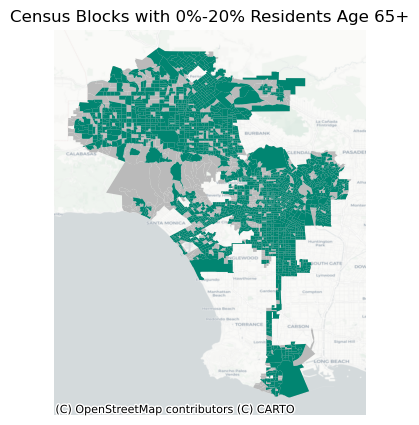

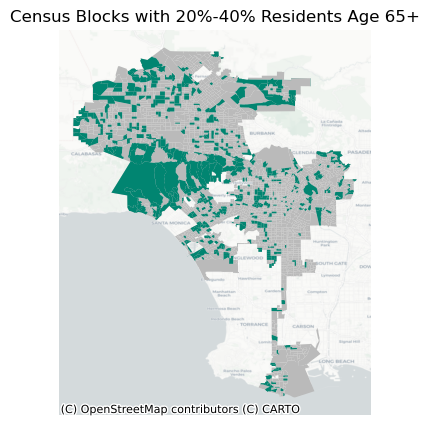

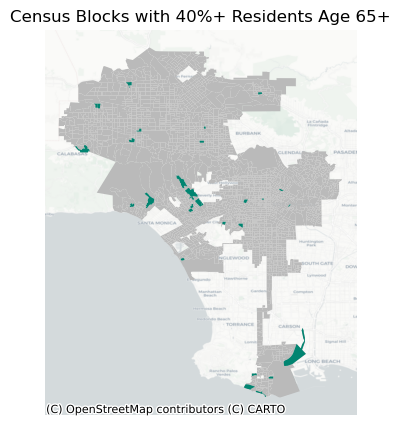

In [5]:
for pct in pctcats:
    fig, ax = plt.subplots(figsize=(5,5))

    # create the map plot
    seniors.plot(ax=ax,
            color='#bababa')

    # create the map plot
    seniors[seniors['pctcat'] == pct].plot(ax=ax,
            # column='pctcat',
            color='#018571')

    # add a title
    ax.set_title('Census Blocks with ' + pct + ' ' + 'Residents Age 65+')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

    # get rid of the axis
    ax.axis('off');

# Metro Micro

Import our metro micro geojson created in week 4

In [6]:
micro = gpd.read_file('data/micro.geojson')
micro.sample(5)

,name,geometry
0,Watts Willowbrook,"POLYGON Z ((-118.26535 33.95297 0.00000, -118...."
3,LAX Update,"POLYGON Z ((-118.44440 33.96200 0.00000, -118...."
4,North Hollywood/Burbank,"POLYGON Z ((-118.34073 34.14307 0.00000, -118...."
7,Pasadena Altadena,"POLYGON Z ((-118.13045 34.20416 0.00000, -118...."
6,UCLA / Westwood,"POLYGON Z ((-118.42059 34.05032 0.00000, -118...."


# 

Map the metro micro zones with folium

In [7]:
m = folium.Map(location=[34.1,-118.3], 
               zoom_start = 10.45,
               tiles='CartoDB positron', 
               attribution='CartoDB')
#plot polygons
for _, r in micro.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In [8]:
m.save('metromicro.html')

## What is the distribution of public transit like in LA? 
In this section, we will look at density of transit stops in the city of Los Angeles, and how that relates to where senior residents are living. We aim to identify whether/where there areas where there are high numbers of senior residents, and comparatively low density of transit options.

First we import data on neighborhood boundaries, transit stop locations, transity stop density, and senior population. The transit stop density and location files are compilations of data developed for the midterm, and saved as files for future use.

In [9]:
#read in transit stop data and create dataframes

#Spatial data for public transit stops in City of LA
transit_stops = gpd.read_file('data/transit_stops.geojson')
#Information on number of public transit stops per 
transit_density = pd.read_csv('data/transit_stopcount.csv')
lowtransitdensebg = gpd.read_file('data/lowdensityblockgroups.geojson')
hightransitdensebg= gpd.read_file('data/highdensityblockgroups.geojson')

#read in LA Times Neighborhood Boundaries 
neighborhoods = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.geojson')

### Map of Transit Stop Locations and Senior Density

First, we look at where public transit stops are located in LA, and how that compares to where seniors are most densely located.

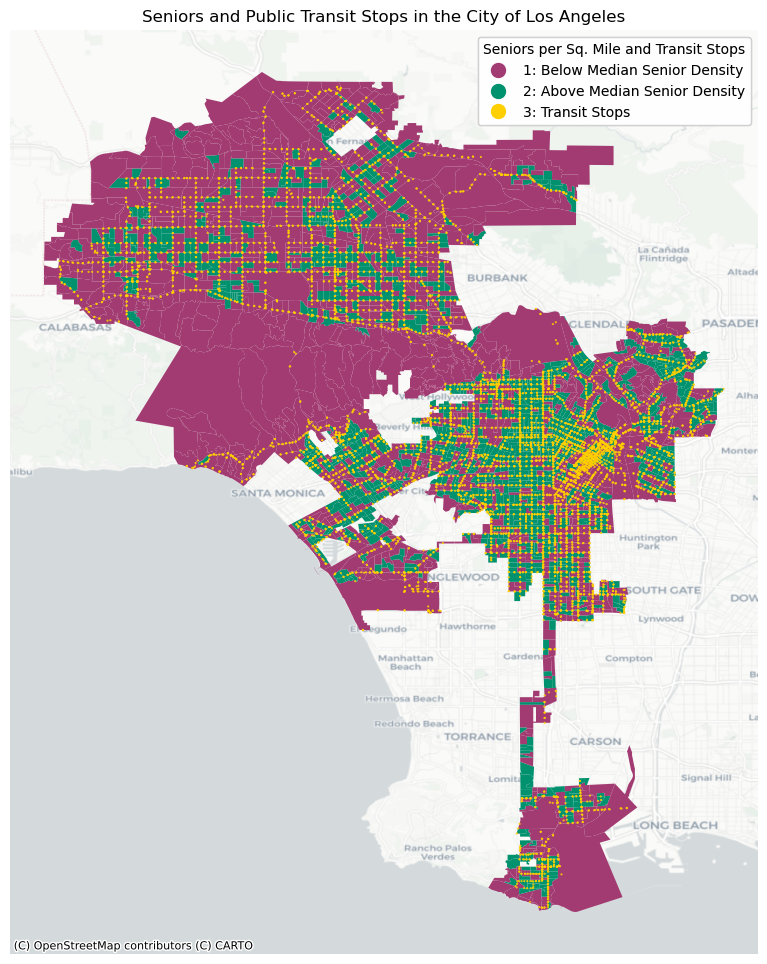

In [39]:
# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: Below Median Senior Density': '#A23B72',
 '2: Above Median Senior Density': '#00916E',
 '3: Transit Stops': '#FFCF00'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.

seniors.loc[seniors["Pop Density"] < 135.000000, "colors"]= '#A23B72' 
seniors.loc[seniors["Pop Density"] >= 135.000000, "colors"]= '#00916E' 
transit_stops["colors"] = '#FFCF00'

#Plot Bus Stops and Metro Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,zorder=1,color=seniors['colors'])

#plot LA metro bus stops
ax2=transit_stops.plot(ax=ax, zorder=2, marker='.',markersize=1,legend=True,color=transit_stops['colors'])
                                                                                                
# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Seniors per Sq. Mile and Transit Stops")
ax.add_artist(leg_points)


#Format plot.
ax.axis('off')
ax.set_title('Seniors and Public Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Map of Density of Transit Stops

Next, we look at density of transit stops to get a better spatial metric. The following map shows block groups in the top and bottom quartiles (highest and lowest) of transit stops/block group. This can help provide a visual of areas that might be good to focus in on for futher analysis.

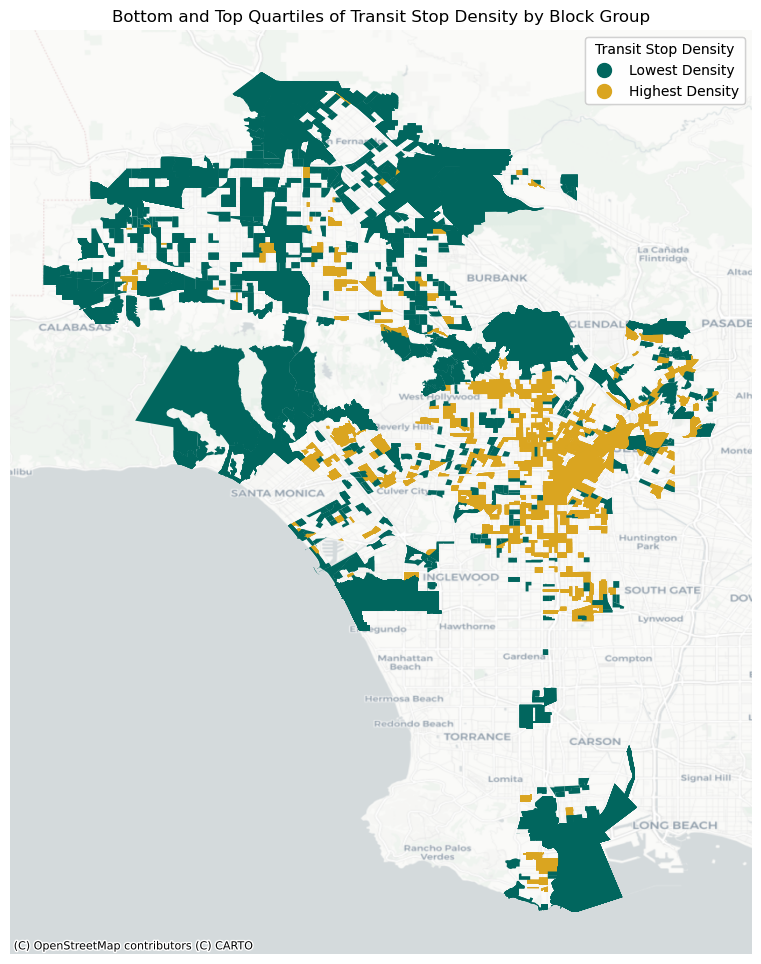

In [14]:
# Add manual legend
color_dict = {'Lowest Density': '#01665e',
 'Highest Density': '#DAA520'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
lowtransitdensebg["colors"] = '#01665e'
hightransitdensebg["colors"] = '#DAA520'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(12,12))
lowtransitdensebg.plot(ax=ax, zorder=2, color=lowtransitdensebg['colors'])
hightransitdensebg.plot(ax=ax, zorder=1, color=hightransitdensebg['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Transit Stop Density")
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Bottom and Top Quartiles of Transit Stop Density by Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Scaling Up to Neighborhoods

Since we hope to pick several neighborhoods to focus in on for more analysis, we need to connect this information to neighborhood boundaries.

In [37]:
#What are the unique neighborhood names? 
neighborhoods.name.unique()

array(['Adams-Normandie', 'Arleta', 'Arlington Heights',
       'Atwater Village', 'Baldwin Hills/Crenshaw', 'Bel-Air',
       'Beverly Crest', 'Beverly Grove', 'Beverlywood', 'Boyle Heights',
       'Brentwood', 'Broadway-Manchester', 'Canoga Park', 'Carthay',
       'Central-Alameda', 'Century City', 'Chatsworth',
       'Chatsworth Reservoir', 'Chesterfield Square', 'Cheviot Hills',
       'Chinatown', 'Cypress Park', 'Del Rey', 'Downtown', 'Eagle Rock',
       'East Hollywood', 'Echo Park', 'El Sereno', 'Elysian Park',
       'Elysian Valley', 'Encino', 'Exposition Park', 'Fairfax',
       'Florence', 'Glassell Park', 'Gramercy Park', 'Granada Hills',
       'Green Meadows', 'Griffith Park', 'Hancock Park', 'Hansen Dam',
       'Harbor City', 'Harbor Gateway', 'Harvard Heights', 'Harvard Park',
       'Highland Park', 'Historic South-Central', 'Hollywood Hills',
       'Hollywood Hills West', 'Hollywood', 'Hyde Park', 'Jefferson Park',
       'Koreatown', 'Lake View Terrace', 'Larc

We will join the transit_stops geodataframe to the LA neighborhood boundaries.

In [44]:
#spatial join of transit stop locations and neighborhood boundaries
transit_stops_nbrhood = gpd.sjoin(transit_stops, neighborhoods)
#display
transit_stops_nbrhood.sample(1)

,stopid,stopname,geometry,colors,index_right,OBJECTID,name
3513,16200,Pico / Flower,POINT (-118.26702 34.04030),#FFCF00,23,24,Downtown


In [52]:
#Use valuecounts to get the number of unique stops per neighborhood
transit_nbrhood_count= transit_stops_nbrhood.value_counts(['name']).reset_index(name='stop_count')
#display statistics 
transit_nbrhood_count.describe()

,stop_count
count,113.000000
mean,90.398230
std,94.149533
min,2.000000
25%,37.000000
50%,71.000000
75%,117.000000
max,850.000000


In [62]:
#Create dataframe of lowest quartile of # of transit stops/neighborhood.
low25_nbhd = transit_nbrhood_count[transit_nbrhood_count["stop_count"] < 37.000000]
#rename columns for plotting
low25_nbhd = low25_nbhd.rename(columns={'stop_count': 'Number of Public Transit Stops', 'name': 'Neighborhood'})

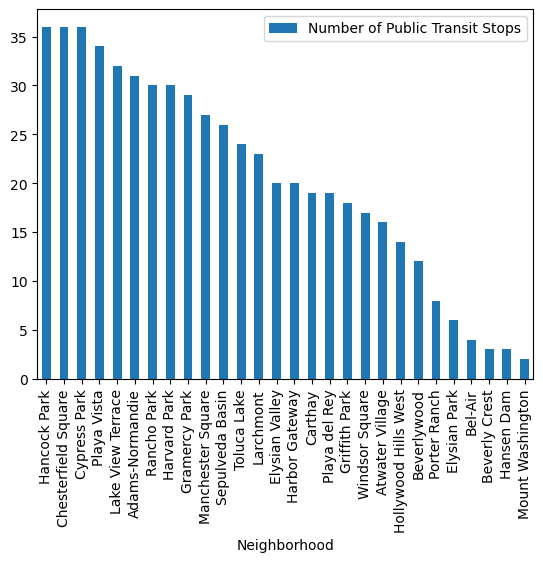

In [64]:
#Plot bar graph
ax = low25_nbhd.plot.bar(x='Neighborhood', y='Number of Public Transit Stops', rot=90)

A next step will include calculating area of the neighborhood boundary polygons and adding a density column to the neighborhood transit stop dataframe, so that we can identify neighborhoods with the lowest geographic density of public transit stops. 